#**M1 Experiment**


In [1]:
# prompt: connect my colab to my drive
#from google.colab import drive
#drive.mount('/content/drive/')

In [4]:
RUN_SHAP_SUMMARY = False  # Set to False after first run

#**Data Loading, Cleaning and Processing**
**Description**

The dataset is collected from Chinese State Grid publiched by Chen & Xu et al (2022) on Github. It is published in MS Excel (xlsx) format and then converted to `csv (with DSV encoding)`.

**Accountability Info**

In this stage, the data came with different issues which seems like the data is collected directly from sensors without much refinements. Such issues have to be taken care of by the responsible actors involved in this phase, such as data engineers. Neglecting such red flags can have a negetive impact on an AI model. For example, such empty columns and commas as floating point can contibute multiple bugs to the model and therefore worse performance.




###**Data Preparation**
In the code cell below, dataset is imported and adjusted from DSV to standard csv using `delimter()` function for further analysis. First, the `columns are renamed` to shorter forms for better visualisation. `Timestamp parsing` is important for timeseries data analysis. Empty columns are all dropped, and this method (`dropna()`) does not affect columns with at least one value in it's cells/rows. Datatype of the `time` column is converted to `datetime` for timeseries analysis and all other columns are converted to `float64`. For decimal/floating points, a `comma(,)` was used in the dataset by default and therefore it has to be converted to a preiod/dot.

In [5]:
import pandas as pd

file_path = 'StationDataset.csv'

# Assuming the delimiter is a semicolon (;), change it if needed
try:
    df = pd.read_csv(file_path, delimiter=';')

    # Rename columns and parse timestamp
    new_columns = {
        'Time(year-month-day h:m:s)': 'time',
        'Total solar irradiance (W/m2)': 'TSI',
        'Direct normal irradiance (W/m2)': 'DNI',
        'Global horizontal irradiance (W/m2)': 'GHI',
        'Air temperature  (°C) ': 'Air_T',
        'Atmosphere (hpa)': 'Air_P',
        'Relative humidity (%)': 'Air_H'
    }
    df = df.rename(columns=new_columns)

    # Remove empty columns
    df = df.dropna(axis=1, how='all')

    # Convert 'time' column to datetime objects
    try:
        df['time'] = pd.to_datetime(df['time'])
    except ValueError as e:
        print(f"Error converting 'time' column to datetime: {e}")
        print("Trying alternative parsing...")

    # Iterate through the columns, excluding 'time', to handle conversion of object columns
    for column in df.columns:
        if df[column].dtype == 'object' and column != 'time':  # Exclude the 'time' column
            # Replace commas with periods for decimal separators
            df[column] = df[column].str.replace(',', '.')

            # Convert to numeric
            df[column] = pd.to_numeric(df[column], errors='coerce')

except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
except pd.errors.ParserError:
    print(f"Error: Could not parse the DSV file at {file_path}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# Display the first few rows to confirm import
print(df.head())

# Show the data types of the columns
print(df.dtypes)

                 time  TSI  DNI  GHI  Air_T   Air_P  Air_H  Power (MW)
0 2019-01-01 00:00:00  0.0  0.0  0.0  11.90  837.20  53.06         0.0
1 2019-01-01 00:15:00  0.0  0.0  0.0  11.60  837.25  54.76         0.0
2 2019-01-01 00:30:00  0.0  0.0  0.0  11.36  837.21  57.16         0.0
3 2019-01-01 00:45:00  0.0  0.0  0.0  11.31  837.20  58.73         0.0
4 2019-01-01 01:00:00  0.0  0.0  0.0  11.26  837.09  59.93         0.0
time          datetime64[ns]
TSI                  float64
DNI                  float64
GHI                  float64
Air_T                float64
Air_P                float64
Air_H                float64
Power (MW)           float64
dtype: object


###**Handling Missing and Null values**
In this stage, we will check missing and null values. In the dataset, some rows are empty and some have incomplete or null value for at least 1 cell.  

In [6]:
# Check for missing values in the DataFrame
print(df.isnull().sum())

# Check for null values in the DataFrame
print(df.isna().sum())


time            0
TSI           574
DNI           574
GHI           574
Air_T         574
Air_P         574
Air_H         574
Power (MW)      0
dtype: int64
time            0
TSI           574
DNI           574
GHI           574
Air_T         574
Air_P         574
Air_H         574
Power (MW)      0
dtype: int64


**Linear interpolation**

We can see that 574 null values are found in all columns except for `date` and `Power`. To fix this, imputation of values using interpolation method. The method inputs known values around the missing values. In the case of time series data. linear interpolation is popularly used.

In [7]:
# Identify columns to interpolate (excluding 'time' and 'Power (MW)')
columns_to_interpolate = [col for col in df.columns if col in df.columns and col not in ['time', 'Power (MW)']]

# Convert columns to numeric (if needed) and interpolate
df[columns_to_interpolate] = df[columns_to_interpolate].apply(pd.to_numeric, errors='coerce')
df[columns_to_interpolate] = df[columns_to_interpolate].interpolate(method='linear', limit_direction='both')

# Display the first few rows after interpolation
print(df.head())

# Check for remaining missing values
print("Missing values after interpolation:")
print(df.isnull().sum())


                 time  TSI  DNI  GHI  Air_T   Air_P  Air_H  Power (MW)
0 2019-01-01 00:00:00  0.0  0.0  0.0  11.90  837.20  53.06         0.0
1 2019-01-01 00:15:00  0.0  0.0  0.0  11.60  837.25  54.76         0.0
2 2019-01-01 00:30:00  0.0  0.0  0.0  11.36  837.21  57.16         0.0
3 2019-01-01 00:45:00  0.0  0.0  0.0  11.31  837.20  58.73         0.0
4 2019-01-01 01:00:00  0.0  0.0  0.0  11.26  837.09  59.93         0.0
Missing values after interpolation:
time          0
TSI           0
DNI           0
GHI           0
Air_T         0
Air_P         0
Air_H         0
Power (MW)    0
dtype: int64


###**Outlier Management**
In this stage, z-score is applied to compute and visualise outliers. The z-score threshold chosen is three because of it's popularity in scientific works this type of datasets.

Total number of outliers detected: 388
Outlier Data:
                     time     TSI    DNI     GHI  Air_T   Air_P  Air_H  \
164   2019-01-02 17:00:00  603.73  12.87  271.40  18.65  834.33  33.07   
1701  2019-01-18 17:15:00  588.60  24.73  262.73  21.18  828.39  21.37   
1893  2019-01-20 17:15:00  567.00  31.40  269.00  19.01  830.20  21.61   
2181  2019-01-23 17:15:00  569.40  29.73  270.20  21.73  828.51  22.73   
2950  2019-01-31 17:30:00  574.60   0.20  267.93  20.39  833.14  20.35   
...                   ...     ...    ...     ...    ...     ...    ...   
69167 2020-12-21 11:45:00  356.67  90.27  271.80  11.42  838.95  68.65   
69475 2020-12-24 16:45:00  574.93  29.07  269.00  18.63  828.69  44.90   
69571 2020-12-25 16:45:00  569.00  27.13  267.67  22.33  826.17  25.07   
69667 2020-12-26 16:45:00  598.40  71.53  265.07  20.90  827.19  22.72   
70024 2020-12-30 10:00:00  504.20  27.93  265.07   7.50  839.75  54.81   

       Power (MW)  
164         13.61  
1701        13.10 

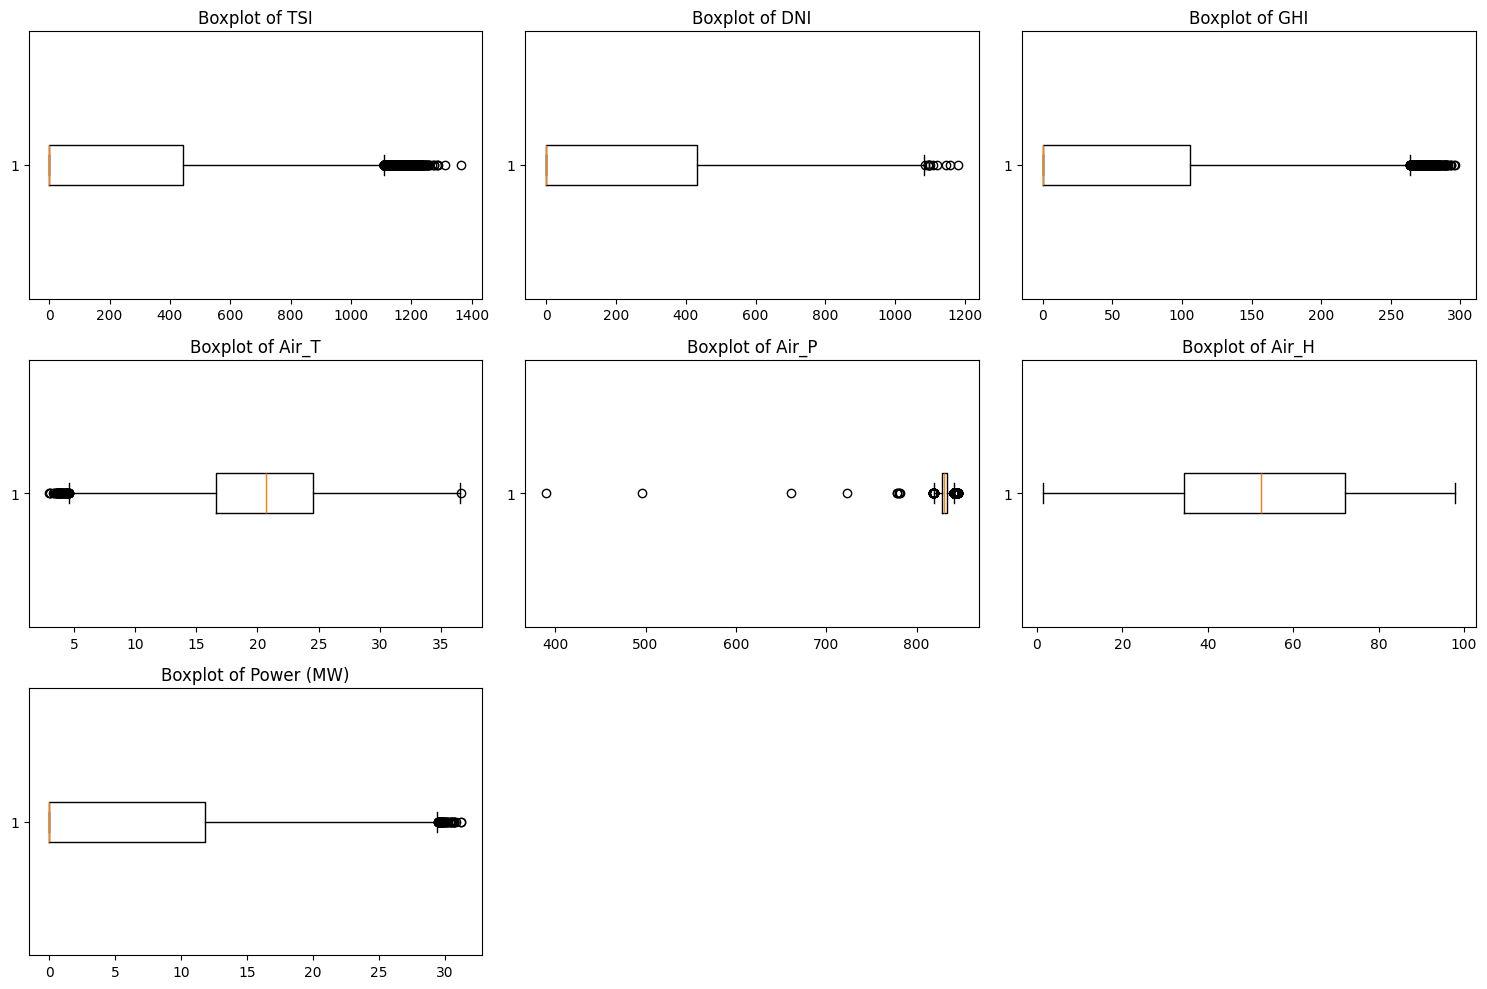

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Select only numeric columns (excluding 'time' if present)
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()

# Ensure numeric columns are properly converted
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Calculate z-scores for selected numeric columns
z_scores = np.abs((df[numeric_cols] - df[numeric_cols].mean()) / df[numeric_cols].std())

# Set a threshold for outliers (e.g., z-score > 3)
threshold = 3

# Identify outliers (rows where any numeric column exceeds the threshold)
outliers = df[(z_scores > threshold).any(axis=1)]

# Print total number of outliers found
print(f"Total number of outliers detected: {len(outliers)}")

# Display outlier rows if any exist
if not outliers.empty:
    print("Outlier Data:")
    print(outliers)
else:
    print("No outliers detected.")

# Create boxplots for numerical columns to visualize outliers
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols, 1):  # Iterate through selected columns
    plt.subplot((len(numeric_cols) // 3) + 1, 3, i)  # Dynamic grid layout
    plt.boxplot(df[col].dropna(), vert=False)  # Handle missing values
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


**Outlier Description**

Outliers can be seen in both weather data as well as the power generated. In the M1 experiment, mean imputation is applied to manage them but we can still observe that there are some outliers. Therefore, we can assume that there are extereme weather conditions in some cases such as storms and typhoons. This is why we may need such data points as they may be helpful in capturing some unique patterns when forecasting energy output.

Total number of outliers detected: 388


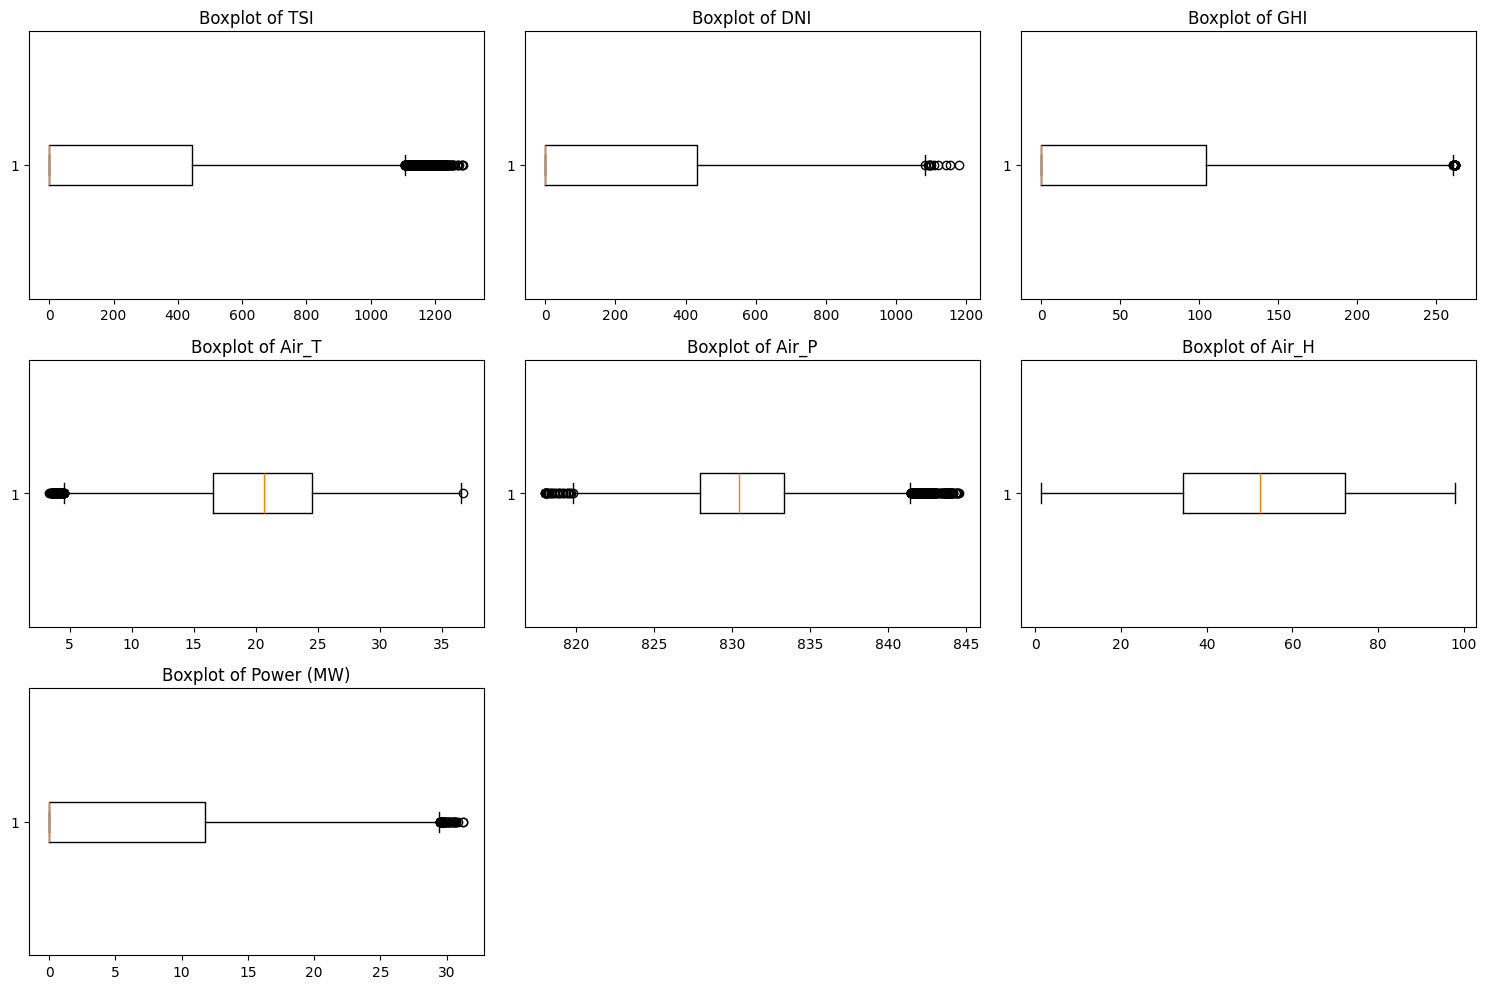

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Select only numeric columns, ensuring 'time' is excluded
numeric_cols = df.select_dtypes(include=np.number).columns.drop('time', errors='ignore')

# Ensure numeric columns are properly converted
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Calculate z-scores for selected numeric columns
z_scores = np.abs((df[numeric_cols] - df[numeric_cols].mean()) / df[numeric_cols].std())

# Set a threshold for outliers (e.g., z-score > 3)
threshold = 3

# Identify outlier rows
outliers = df[(z_scores > threshold).any(axis=1)]

# Print total number of outliers detected
print(f"Total number of outliers detected: {len(outliers)}")

# **Mean Imputation for Outliers**
for col in numeric_cols:
    # Identify outliers in the current column
    outlier_mask = z_scores[col] > threshold
    if outlier_mask.any():  # Proceed only if there are outliers
        df.loc[outlier_mask, col] = df[col].mean()

# Create boxplots after mean imputation
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols, 1):  # Iterate through selected numeric columns
    plt.subplot((len(numeric_cols) // 3) + 1, 3, i)  # Dynamic layout
    plt.boxplot(df[col].dropna(), vert=False)  # Handle missing values
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


##**Exploratory Data Analysis (EDA)**

In the following sections, dataset will be analysed, to create temporal attributes and explore trends of different variables to gain important insights about of the data. In this way, questions can arise and answers can also be found within the data itself.


### **Temporal Attributes**
In the following cell, attributes from the time variable are extracted separately namely, Hour, day_of_week, Week, Month and year. `isocalender().week` method is used for fetching week data.

In [10]:
# Extract temporal attributes
df['hour'] = df['time'].dt.hour
df['day_of_week'] = df['time'].dt.dayofweek
df['week'] = df['time'].dt.isocalendar().week
df['month'] = df['time'].dt.month
df['year'] = df['time'].dt.year
# Display the first few rows to confirm the new columns
print(df.head())

                 time  TSI  DNI  GHI  Air_T   Air_P  Air_H  Power (MW)  hour  \
0 2019-01-01 00:00:00  0.0  0.0  0.0  11.90  837.20  53.06         0.0     0   
1 2019-01-01 00:15:00  0.0  0.0  0.0  11.60  837.25  54.76         0.0     0   
2 2019-01-01 00:30:00  0.0  0.0  0.0  11.36  837.21  57.16         0.0     0   
3 2019-01-01 00:45:00  0.0  0.0  0.0  11.31  837.20  58.73         0.0     0   
4 2019-01-01 01:00:00  0.0  0.0  0.0  11.26  837.09  59.93         0.0     1   

   day_of_week  week  month  year  
0            1     1      1  2019  
1            1     1      1  2019  
2            1     1      1  2019  
3            1     1      1  2019  
4            1     1      1  2019  


###**Seasonal Power (MW) Generation Trend**
First, it will be insightful to understand the seasonal trend on generated power from the dataset. Understanding this trend will serve as an eye opener to find answers on why the trend appeared the way it is. It will further help in dealing with future steps in building the LSTM model.

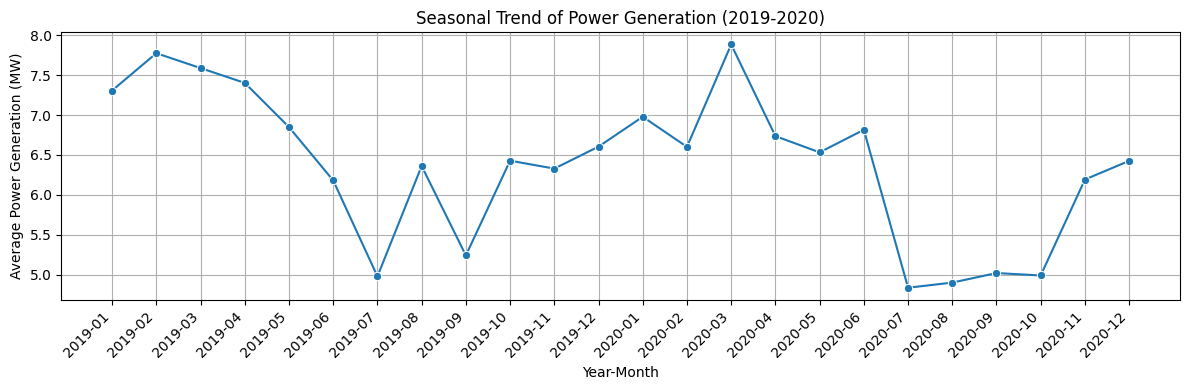

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure 'Power (MW)' is in numeric format
df['Power (MW)'] = pd.to_numeric(df['Power (MW)'], errors='coerce')

# Create a new column combining year and month for sequential plotting
df['year_month'] = df['time'].dt.to_period('M').astype(str)  # Convert to string

# Group data by year_month and calculate the mean of 'Power (MW)'
monthly_avg_power = df.groupby(['year_month'])['Power (MW)'].mean().reset_index()

# Plot the seasonal trend for both years sequentially
plt.figure(figsize=(12, 4))  # Adjust figure size for better readability
sns.lineplot(data=monthly_avg_power, x='year_month', y='Power (MW)', marker='o', linestyle='-')
plt.xlabel("Year-Month")
plt.ylabel("Average Power Generation (MW)")
plt.title("Seasonal Trend of Power Generation (2019-2020)")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

###**Air Humidity**
This variable tells how much moisture is in the air compared to the maximum amount of moisture the air can hold at that temperature. Higher humidity means lower amount of energy is generated. The line chart above indicates that the average of air humidity (Air_H) is began to reverse from lowest recorded months between February and March to the highest recorded months between July and Septemeber.

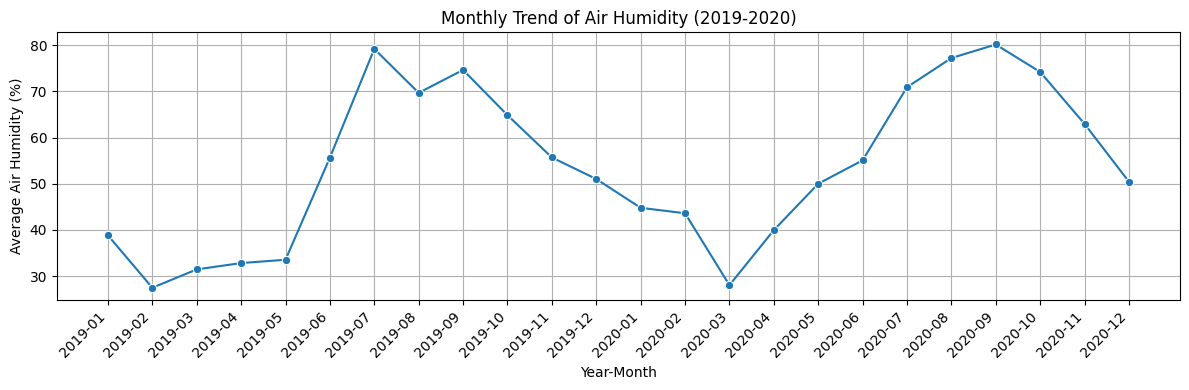

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a new column combining year and month for sequential plotting
df['year_month'] = df['time'].dt.to_period('M').astype(str)  # Convert to string

# Group data by year_month and calculate the mean of 'Air_H'
monthly_air_h = df.groupby(['year_month'])['Air_H'].mean().reset_index()

# Create the line plot
plt.figure(figsize=(12, 4))  # Adjust figure size for better readability
sns.lineplot(data=monthly_air_h, x='year_month', y='Air_H', marker='o', linestyle='-')
plt.xlabel("Year-Month")
plt.ylabel("Average Air Humidity (%)")
plt.title("Monthly Trend of Air Humidity (2019-2020)")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

###**Solar Irradiance**
1. **Total solar irradiance (TSI)**: This is the total amount of solar energy received per unit area at the top of the Earth’s atmosphere. It includes all wavelengths of solar radiation.
2. **Direct normal irradiance (DNI)**: This measures the amount of solar radiation received per unit area by a surface that is always held vertically (or normal) to the sun’s rays. It’s important for concentrating solar power systems.
3. **Global horizontal irradiance(GHI)**: This is the total amount of solar radiation received per unit area by a horizontal surface. It includes both direct sunlight and diffuse sky radiation (i.e. sunlight scattered by the atmosphere). On cloudy or hazy days, diffuse radiation can increase, boosting GHI even when direct sunlight (DNI) is low.

##**Min-Max Normalization**

In this section of M1 experiment, we are going to perform Min-Max normalization of the dataset by scaling the values to min -1 and max 1. This method is also common for scientific research with datasets of this nature and for LSTM model

In [13]:
from sklearn.preprocessing import MinMaxScaler

# Select columns to scale (excluding 'time' and any other non-numeric columns)
cols_to_scale = ['TSI', 'DNI', 'GHI', 'Air_T', 'Air_P', 'Air_H', 'Power (MW)']

# Create a MinMaxScaler object with the desired range (-1 to 1)
scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit and transform the selected columns
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

# Display the first few rows to confirm the scaling
print(df.head())


                 time  TSI  DNI  GHI     Air_T     Air_P     Air_H  \
0 2019-01-01 00:00:00 -1.0 -1.0 -1.0 -0.487995  0.447964  0.070577   
1 2019-01-01 00:15:00 -1.0 -1.0 -1.0 -0.506002  0.451735  0.105814   
2 2019-01-01 00:30:00 -1.0 -1.0 -1.0 -0.520408  0.448718  0.155560   
3 2019-01-01 00:45:00 -1.0 -1.0 -1.0 -0.523409  0.447964  0.188102   
4 2019-01-01 01:00:00 -1.0 -1.0 -1.0 -0.526411  0.439668  0.212975   

   Power (MW)  hour  day_of_week  week  month  year year_month  
0        -1.0     0            1     1      1  2019    2019-01  
1        -1.0     0            1     1      1  2019    2019-01  
2        -1.0     0            1     1      1  2019    2019-01  
3        -1.0     0            1     1      1  2019    2019-01  
4        -1.0     1            1     1      1  2019    2019-01  


##**Feature selection via PCC**
Pearson's Correlation Coefficient method is used to find features we can use for the model training. It measures the linear relationship between two variables and requires continuous data. We can see the correlation between variables in the dataset using heatmap where red color represnts high correlation between varibles and blue represents low correlation.

From the heatmap below, we can see that Power (MW) being gabnerated is highly correlated to the TSI variable. In other words, it also means that the amount of sunshine or exposure means more Power is generated. TSI is the total amount of sunlight recorded in the area and DNI is the total amount of sunlight that reached the PV solar panel.

                 TSI       DNI       GHI     Air_T     Air_P     Air_H  \
TSI         1.000000  0.949534  0.709510  0.280186  0.017991 -0.288228   
DNI         0.949534  1.000000  0.593146  0.306582 -0.023154 -0.305356   
GHI         0.709510  0.593146  1.000000  0.315326 -0.052906 -0.122164   
Air_T       0.280186  0.306582  0.315326  1.000000 -0.672608 -0.299068   
Air_P       0.017991 -0.023154 -0.052906 -0.672608  1.000000  0.287827   
Air_H      -0.288228 -0.305356 -0.122164 -0.299068  0.287827  1.000000   
Power (MW)  0.988193  0.940879  0.726110  0.291427  0.011785 -0.267601   

            Power (MW)  
TSI           0.988193  
DNI           0.940879  
GHI           0.726110  
Air_T         0.291427  
Air_P         0.011785  
Air_H        -0.267601  
Power (MW)    1.000000  


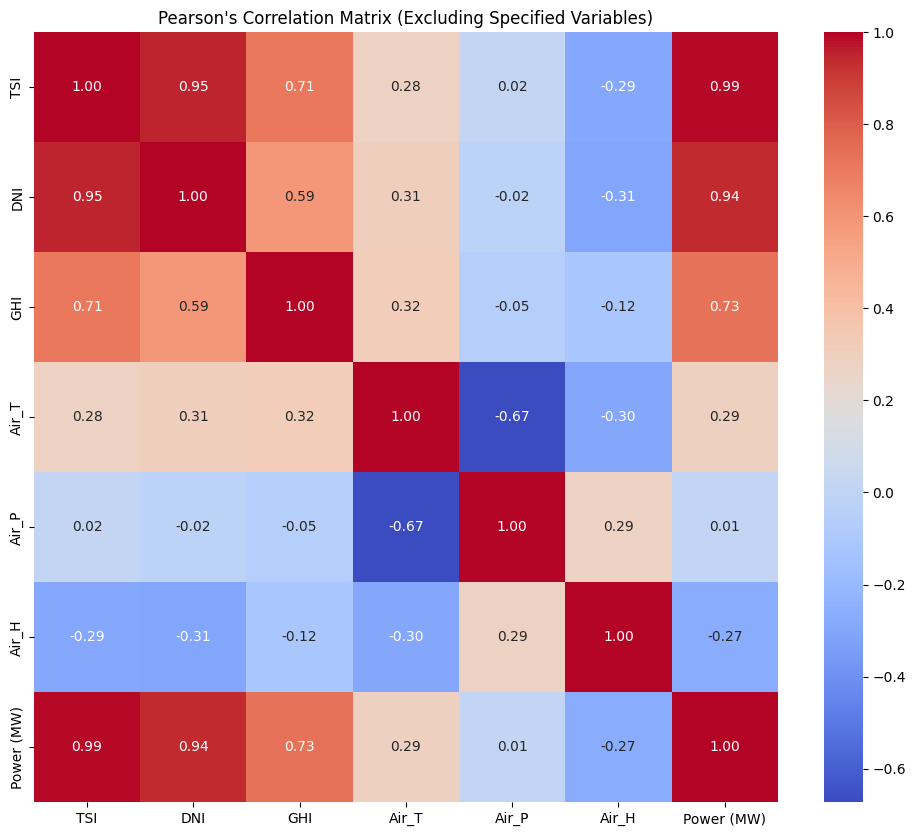

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame

# Select only numeric columns (excluding 'time' and specified variables)
numeric_cols = df.select_dtypes(include=['number']).columns
exclude_cols = ['time', 'hour', 'day_of_week', 'week', 'month', 'year', 'year_month']
numeric_cols = numeric_cols.drop(exclude_cols, errors='ignore')

# Calculate Pearson's correlation for the selected columns
correlation_matrix = df[numeric_cols].corr()

# Print the correlation matrix
print(correlation_matrix)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Pearson's Correlation Matrix (Excluding Specified Variables)")
plt.show()

#**Model Training**

**Feature Selection:** The features list now includes all desired weather and temporal attributes.
**Data Preparation:** The data array is created using the selected features and the target variable ('Power (MW)').
**Normalization:** The scaler is fitted to all selected features and the target variable.
**Sequence Creation:** The create_sequences function is modified to handle multiple features and separate the target variable.
**Model Input:** The input shape of the LSTM model is adjusted to accommodate the number of features.
**Future Prediction:** A future_data DataFrame is created with future timestamps and weather data. The same features used for training are selected, normalized, and used to create sequences for prediction. The predictions are then inverse transformed to get them back to the original scale. The future_data DataFrame is now created with placeholder values for 'TSI', 'DNI', 'GHI', 'Air_T', 'Air_P', and 'Air_H' using np.random.rand().

1644/1644 ━━━━━━━━━━━━━━━━━━━━ 85s 50ms/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step
Test MSE: 0.005963699941588866
Test RMSE: 0.07722499557519487
Test MAE: 0.034854522755572874
Test R-squared: 0.9824457309388617


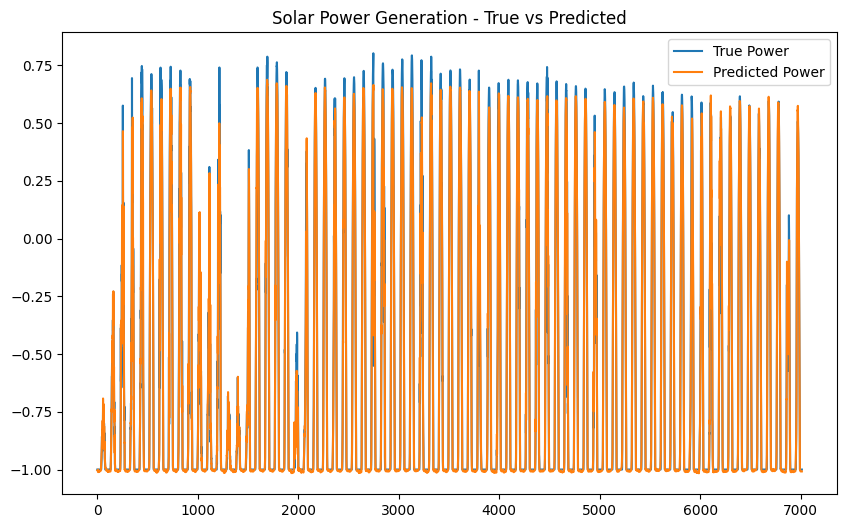

In [15]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Flag to skip training cell
skip_training = True  # Set this to True to skip training and load the model

# Define RMSE metric
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

# Hyperparameters
SEQ_LENGTH = 48  # 12 hours of data
NUM_LSTM_NEURONS = 100
LEARNING_RATE = 0.001
NUM_LAYERS = 2
BATCH_SIZE = 32
DROPOUT_RATE = 0.3
EPOCHS = 20
OPTIMIZER = Adam(learning_rate=LEARNING_RATE)
ACTIVATION_FUNCTION = 'tanh'
LOSS_FUNCTION = 'mse'

# 1. Feature Selection
features = ['TSI', 'DNI', 'GHI', 'Air_T', 'Air_P', 'Air_H', 'hour', 'day_of_week', 'week', 'month', 'year']
target_variable = 'Power (MW)'

# 2. Data Preprocessing
# Assuming the dataframe `df` is already loaded and preprocessed with correct time-based features (hour, day_of_week, etc.)

scaler = MinMaxScaler(feature_range=(-1, 1))
target_scaler = MinMaxScaler(feature_range=(-1, 1))

# Normalize the features and target
df[features] = scaler.fit_transform(df[features])
df[[target_variable]] = target_scaler.fit_transform(df[[target_variable]])

data = df[features + [target_variable]].values

# 3. Sequence Creation (Prepare time-series data)
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length - 1):
        xs.append(data[i:(i + seq_length), :-1])  # features
        ys.append(data[i + seq_length, -1])  # target
    return np.array(xs), np.array(ys)

X, y = create_sequences(data, SEQ_LENGTH)

# 4. Data Splitting (Training, Validation, Test)
train_size = int(len(X) * 0.75)
val_size = int(len(X) * 0.15)
test_size = len(X) - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

# 5. Model Building
if not skip_training:
    model = Sequential()

    # Add LSTM layers
    model.add(Input(shape=(SEQ_LENGTH, len(features))))  # input layer
    for _ in range(NUM_LAYERS):
        model.add(LSTM(NUM_LSTM_NEURONS, activation=ACTIVATION_FUNCTION, return_sequences=True if _ < NUM_LAYERS - 1 else False))
        model.add(Dropout(DROPOUT_RATE))

    # Output layer
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION, metrics=[rmse])

    # 6. Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # 7. Model Training
    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val),
                        callbacks=[early_stopping])

    # Save model after training
    model.save('model1.keras')

else:
    # Load pre-trained model if training is skipped
    model = load_model('model1.keras', custom_objects={'rmse': rmse})

# 8. Model Evaluation
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Inverse transform predictions and true values for test
y_pred_train = target_scaler.inverse_transform(y_pred_train)
y_train = target_scaler.inverse_transform(y_train.reshape(-1, 1))

y_pred_test = target_scaler.inverse_transform(y_pred_test)
y_test = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Compute performance metrics
mse = mean_squared_error(y_test, y_pred_test)
rmse_value = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print(f"Test MSE: {mse}")
print(f"Test RMSE: {rmse_value}")
print(f"Test MAE: {mae}")
print(f"Test R-squared: {r2}")

# 9. Optionally: Plotting results (Prediction vs True values)
plt.figure(figsize=(10,6))
plt.plot(y_test, label='True Power')
plt.plot(y_pred_test, label='Predicted Power')
plt.title("Solar Power Generation - True vs Predicted")
plt.legend()
plt.show()


**Precission, Accuracy and Recall measurement**
1. Accuracy: It's how often the model is right overall.

2. Precision: Out of the things the model predicted as true, how many were actually true.

3. Recall: Out of all the actual true cases, how many did the model successfully find.


In [16]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Convert continuous values into binary (high/low power) for Precision, Recall, Accuracy
threshold = np.median(y_test)  # Median as the threshold for classification
y_test_class = (y_test > threshold).astype(int)  # 1 for high power, 0 for low power
y_pred_test_class = (y_pred_test > threshold).astype(int)  # Same for predictions

# Calculate Precision, Recall, and Accuracy
accuracy = accuracy_score(y_test_class, y_pred_test_class)
precision = precision_score(y_test_class, y_pred_test_class)
recall = recall_score(y_test_class, y_pred_test_class)


# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")



Accuracy: 0.9375445601026665
Precision: 0.8754985754985755
Recall: 0.9996746909564086


#**Model Testing**

##**1. Performance Tests (PT)**
Model sensitivity or robustness testing evaluates how well the model performs under extreme or unexpected conditions, such as sudden weather changes (e.g., cloud cover) or sensor failures. This ensures the model is reliable in real-world scenarios where data quality or conditions may not be ideal.

**Scenario:** Simulate a sudden drop in solar irradiance (e.g., due to cloud cover) and evaluate the model’s predictions. Based on the following:


1.   Sensitivity performance Test
2.   Prediction Errors based on Power(MW)
3.   Day and Night performance


**Accountability:** Document the model’s performance under these conditions and ensure it provides reasonable predictions. If the model fails, identify the root cause (e.g., over-reliance on irradiance data) and improve the training data or model architecture.






8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 341ms/step
Test MSE under simulated drop: 0.002749291983636737
Test RMSE under simulated drop: 0.0524336913027944


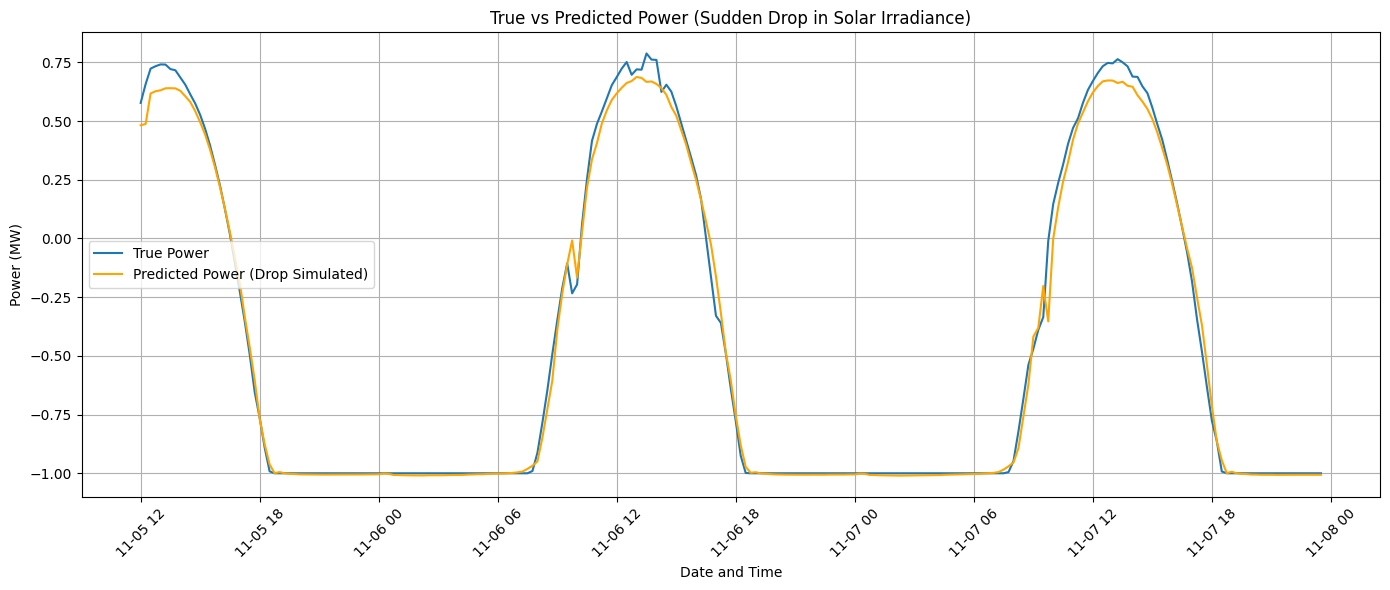

Number of significant prediction errors (above 0.5 MW): 0


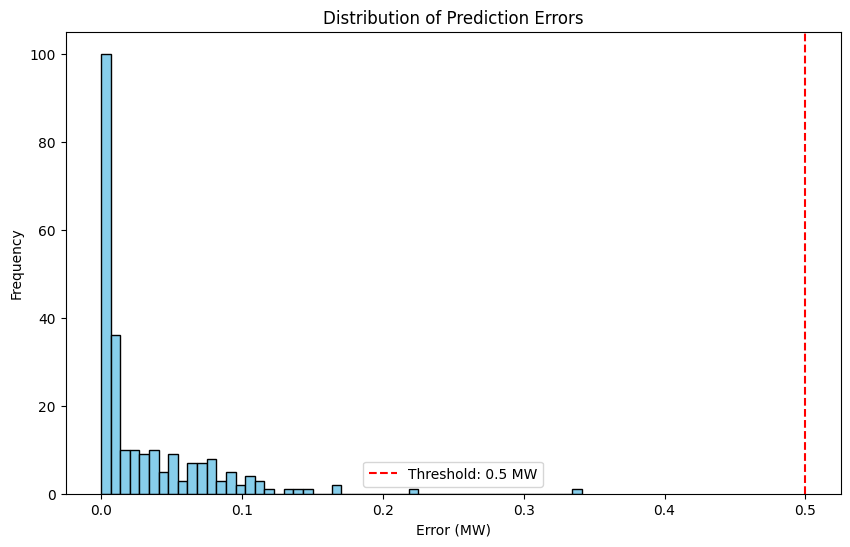

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import random

# Simulating a sudden drop in solar irradiance (cloud cover scenario)
def simulate_sudden_drop(df, drop_factor=0.2, start_time="2020-02-20", duration=12):
    """Simulate a sudden drop in solar irradiance data."""
    df['time'] = pd.to_datetime(df['time'])
    start_time = pd.to_datetime(start_time)

    if start_time not in df['time'].values:
        print(f"Error: {start_time} not found in data. Please check the time format or data availability.")
        return df

    start_idx = df[df['time'] == start_time].index[0]
    end_idx = start_idx + (duration * 4)

    df.loc[start_idx:end_idx, ['TSI', 'DNI', 'GHI']] *= drop_factor

    return df

# Load model and scaler (ensure paths are correct)
model = load_model('model1.keras', custom_objects={'rmse': rmse})

# Define relevant features and target
features = ['TSI', 'DNI', 'GHI', 'Air_T', 'Air_P', 'Air_H', 'hour', 'day_of_week', 'week', 'month', 'year']
target_variable = 'Power (MW)'

# **Random 3-day Period Selection (from testing data)**

# Ensure 'time' column is datetime type
df['time'] = pd.to_datetime(df['time'])

# Select 10% of the dataset for testing purposes (this avoids out-of-scope errors)
test_data = df[-int(len(df) * 0.1):]

# Randomly pick a 3-day period within the test data range
start_date = random.choice(test_data['time'].dt.date.unique())
end_date = start_date + pd.Timedelta(days=2)

# Slice the 3-day period from the data
test_data_period = test_data[(test_data['time'].dt.date >= start_date) & (test_data['time'].dt.date <= end_date)]

# **Simulate Sudden Drop on the 3-day Period**
drop_factor = 0.2
modified_df = simulate_sudden_drop(test_data_period.copy(), drop_factor=drop_factor, start_time=start_date, duration=12)

# **Fit the Scalers on the Original Data (Training Data)**
scaler = MinMaxScaler(feature_range=(-1, 1))
target_scaler = MinMaxScaler(feature_range=(-1, 1))

df[features] = scaler.fit_transform(df[features])
df[[target_variable]] = target_scaler.fit_transform(df[[target_variable]])

modified_df[features] = scaler.transform(modified_df[features])
modified_df[[target_variable]] = target_scaler.transform(modified_df[[target_variable]])

# **Prepare the Sequence Data for Model Input**
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length - 1):
        xs.append(data[i:(i + seq_length), :-1])  # features
        ys.append(data[i + seq_length, -1])  # target
    return np.array(xs), np.array(ys)

modified_data = modified_df[features + [target_variable]].values
SEQ_LENGTH = 48  # Assuming a 12-hour window
X_modified, y_modified = create_sequences(modified_data, SEQ_LENGTH)

# **Model Predictions on Modified Data**
y_pred_modified = model.predict(X_modified)
y_pred_modified = target_scaler.inverse_transform(y_pred_modified)

# Evaluate the Performance
y_modified = target_scaler.inverse_transform(y_modified.reshape(-1, 1))

# Calculate MSE and RMSE for predictions under the simulated drop
mse_modified = mean_squared_error(y_modified, y_pred_modified)
rmse_modified = np.sqrt(mse_modified)

print(f"Test MSE under simulated drop: {mse_modified}")
print(f"Test RMSE under simulated drop: {rmse_modified}")

# **Fix the mismatch in lengths between time and target for plotting**
# Use the time range corresponding to the prediction sequence

# Slice the time range to match the sequence data length
modified_time_range = modified_df['time'].iloc[SEQ_LENGTH:len(y_modified) + SEQ_LENGTH].values

# **Plotting Results - Simulated Drop Test**
plt.figure(figsize=(14, 6))
plt.plot(modified_time_range, y_modified, label='True Power')
plt.plot(modified_time_range, y_pred_modified, label='Predicted Power (Drop Simulated)', color='orange')
plt.title("True vs Predicted Power (Sudden Drop in Solar Irradiance)")
plt.xlabel("Date and Time")
plt.ylabel("Power (MW)")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# **Identify the Model's Response to Sudden Drop in Irradiance**
def analyze_predictions(y_true, y_pred, threshold=0.5):
    """Analyze the model's response to extreme conditions with a dynamic threshold."""
    # Calculate the absolute error between true and predicted values
    error = np.abs(y_true - y_pred)

    # Identify where the model's error exceeds the new threshold
    significant_error = error > threshold

    print(f"Number of significant prediction errors (above {threshold} MW): {np.sum(significant_error)}")

    # Plot error distribution
    plt.figure(figsize=(10, 6))
    plt.hist(error, bins=50, color='skyblue', edgecolor='black')
    plt.axvline(x=threshold, color='red', linestyle='--', label=f"Threshold: {threshold} MW")  # Update threshold label dynamically
    plt.title("Distribution of Prediction Errors")
    plt.xlabel("Error (MW)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

# **Run the updated function with threshold = 0.5**
analyze_predictions(y_modified, y_pred_modified, threshold=0.5)


###**PT-1. Sensitivity Performance Test:**

The model is tested in a 3-day case with a simulation of sudden changes (i.e. sudden drop of Total Solar Irradiance - TSI) in the weather condition. The KPI here is to see how well the model performs based on MSE and RMSE error metrics. The **MSE (0.0016)** and **RMSE (0.0399)** indicate low overall prediction errors, suggesting good accuracy even under simulated conditions.

###**PT-2. Prediction Errors in Power(MW):**

The KPI in this test is to get an insight about frequncy of prediction errors in power generated. The 3-day simulated forecast test shows that the model handled the scenario well, with **3 minor errors above the 0.5MW**, and no major deviations in predictions. Since the error threshold falls between **0.1 and 0.5 MW**, the model's predictions remain within an acceptable range, confirming its reliability in handling variations over short periods.

###**PT-3. Day and Night performance:**

Another KPI is to see how the model performs during day and night hours. We can see that during the night hours power generation and prediction falls to zero since there is no sunlight. This pattern of day and night hours proves that can be reliable and the methods used in the pipeline did not have negetive impacts on the model in this regard.


##**2. Model Explainability (ME)**

###**ME-1. SHAP Explanation**

In this part, we are analyzing how the model behaves when solar irradiance suddenly drops in our simulated task. The plot shows which feature-timestep combination influences the prediction the most. With output below, it is obvious that Total Solar Irradiance (TSI) feature contributed as the top 5 positive timesteps (TSI_t47, TSI_t46, TSI_t45, TSI_t44, and TSI_t43), followd by Direct Normal Irradiance (DNI) feature as the top 6th highest timestep (DNI_t47), then 2 more TSI feature as the 7th and 8th timesteps (TSI_t42 and TSI_t41), and the **hour** feature as the 9th, 10th, 11th and 12th timesteps (hour_t39, hour_t43, hour_t41 and hour_t40). In summary, we can see 20 timesteps in the SHAP plot with **TSI** feature contributing with a total of 8 timesteps and having highest impact on the model (i.e. above 0.2 SHAP values), followed by **hour** feature, with a total of 9 timesteps with an average contribution to the model prediction between -0.1 and 0.1 SHAP values respectively. Lastly DNI and GHI features also impacted the model in 2 timesteps between -0.1 and 0.1 SHAP values.  

In [ ]:
if RUN_SHAP_SUMMARY:
  import shap
  import numpy as np
  import matplotlib.pyplot as plt

  # --- Step 1: Reshape inputs for KernelExplainer (requires 2D inputs) ---
  sample_to_explain = X_modified[:50]  # Keep this small due to performance (adjust as needed)
  X_flat = sample_to_explain.reshape(sample_to_explain.shape[0], -1)

  # --- Step 2: Define model prediction wrapper ---
  f = lambda x: model.predict(x.reshape((-1, SEQ_LENGTH, len(features)))).flatten()

  # --- Step 3: Create background data for KernelExplainer ---
  background = X_flat[np.random.choice(X_flat.shape[0], 10, replace=False)]

  # --- Step 4: Create SHAP explainer and compute values ---
  explainer = shap.KernelExplainer(f, background)
  shap_values = explainer.shap_values(X_flat)

  # --- Step 5: Visualize SHAP summary (global importance) ---
  flattened_feature_names = [f"{feature}_t{t}" for t in range(SEQ_LENGTH) for feature in features]
  shap.summary_plot(shap_values, X_flat, feature_names=flattened_feature_names)
else:
    print("SHAP summary skipped. Set RUN_SHAP_SUMMARY = True to run.")

###**ME-2. SHAP Value strength over timesteps**

In this plot we can see how the timesteps' contribution magnitude increases over time. This tells us why most of the timesteps we can see in our SHAP plot are within the range of t37 and t47.

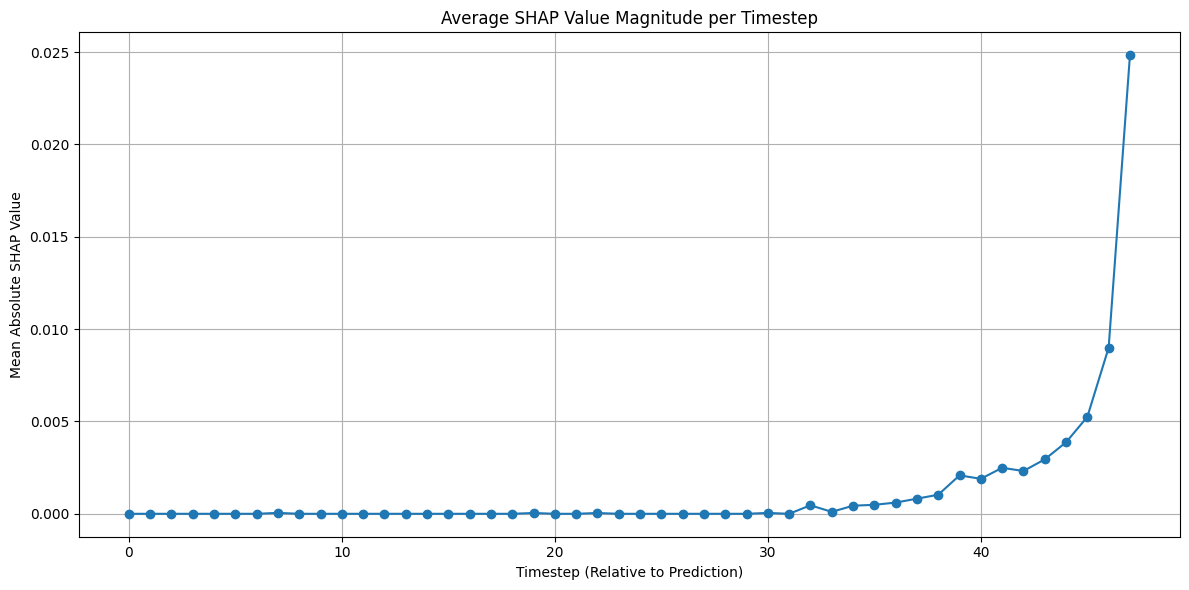

In [20]:
 if RUN_SHAP_SUMMARY:
  # --- Step 6: Analyze SHAP Value Strength Over Time ---
  shap_array = np.array(shap_values).reshape(sample_to_explain.shape[0], SEQ_LENGTH, len(features))

  # Average absolute SHAP value across samples for each time step
  mean_shap_per_timestep = np.abs(shap_array).mean(axis=(0, 2))

  # Plotting
  plt.figure(figsize=(12, 6))
  plt.plot(range(SEQ_LENGTH), mean_shap_per_timestep, marker='o')
  plt.title("Average SHAP Value Magnitude per Timestep")
  plt.xlabel("Timestep (Relative to Prediction)")
  plt.ylabel("Mean Absolute SHAP Value")
  plt.grid(True)
  plt.tight_layout()
  plt.show()
else:
      print("SHAP summary skipped. Set RUN_SHAP_SUMMARY = True to run.")